In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, Add, GlobalAveragePooling2D, Dense, Concatenate, Multiply, UpSampling2D, Conv2DTranspose, Attention, MaxPooling2D, Dropout, Flatten
import cv2
import numpy as np
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')
import random
import os
from sklearn.model_selection import train_test_split



img_height, img_width = 224, 224
batch_size = 8

def reduce_noise(img):
    img = cv2.medianBlur(img, 5)
    return img

train_datagen = ImageDataGenerator(
    preprocessing_function=reduce_noise,
    rescale=1./255,             
    rotation_range=20,           
    shear_range=0.2,            
    zoom_range=0.2,     
    fill_mode='nearest'
)


val_datagen = ImageDataGenerator(
    preprocessing_function=reduce_noise,
    rescale=1./255
)

test_datagen = ImageDataGenerator(
    preprocessing_function=reduce_noise,
    rescale=1./255
)


In [2]:
train_generator = train_datagen.flow_from_directory(
    'C:/Users/SKH/Desktop/mvv/train',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

val_generator = val_datagen.flow_from_directory(
    'C:/Users/SKH/Desktop/mvv/val',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    'C:/Users/SKH/Desktop/mvv/test',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 352 images belonging to 32 classes.
Found 128 images belonging to 32 classes.
Found 64 images belonging to 32 classes.


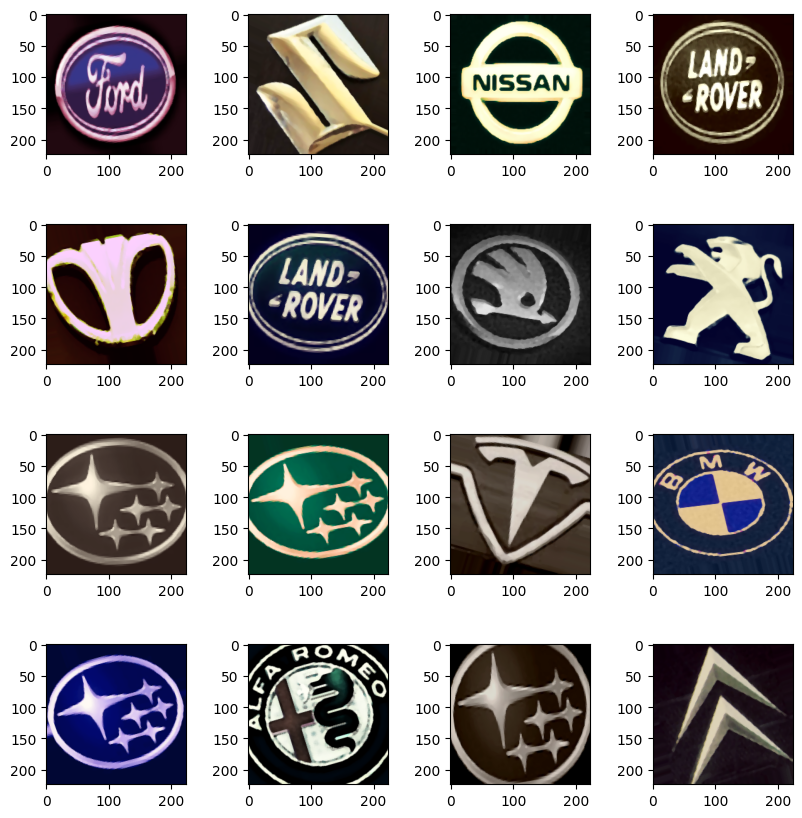

In [3]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
plt.subplots_adjust(hspace=0.5)
for i in range(16):
    plt.subplot(4, 4, i+1)
    for X_batch, Y_batch in train_generator:
        img = X_batch[0]
        
        plt.imshow(img)
        break
plt.show()



In [4]:

import tensorflow as tf

class Attention(tf.keras.layers.Layer):
    def __init__(self, filters):
        super(Attention, self).__init__()
        self.filters = filters
        self.conv1 = tf.keras.layers.Conv2D(filters=filters, kernel_size=1, strides=1, padding='same')
        self.conv2 = tf.keras.layers.Conv2D(filters=1, kernel_size=1, strides=1, padding='same')

    def call(self, inputs):
        x = tf.keras.activations.relu(self.conv1(inputs))
        attention_weights = tf.nn.sigmoid(self.conv2(x))
        attention_output = tf.multiply(x, attention_weights)
        return attention_output


def create_cnn_model1(input_shape, num_classes):
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        tf.keras.layers.MaxPooling2D((2, 2)),
        Attention(32),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        Attention(64),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    return model

def create_inception_module(x, filters):
    tower_1 = tf.keras.layers.Conv2D(filters, (1, 1), padding='same', activation='relu')(x)
    tower_1 = tf.keras.layers.Conv2D(filters, (3, 3), padding='same', activation='relu')(tower_1)

    tower_2 = tf.keras.layers.Conv2D(filters, (1, 1), padding='same', activation='relu')(x)
    tower_2 = tf.keras.layers.Conv2D(filters, (5, 5), padding='same', activation='relu')(tower_2)

    tower_3 = tf.keras.layers.MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
    tower_3 = tf.keras.layers.Conv2D(filters, (1, 1), padding='same', activation='relu')(tower_3)

    output = tf.keras.layers.concatenate([tower_1, tower_2, tower_3], axis=3)
    return output

def create_cnn_model2(input_shape, num_classes):
    input_tensor = Input(shape=input_shape)

    x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(input_tensor)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    x = Attention(64)(x)

    x = create_inception_module(x, 128)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    x = Attention(128)(x)

    x = create_inception_module(x, 256)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    x = Attention(256)(x)

    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    output = Dense(num_classes, activation='softmax')(x)

    model = Model(input_tensor, output)
    return model

input_shape = (224, 224, 3)


input_tensor = Input(shape=input_shape)


model1 = create_cnn_model1(input_shape, 32)
output1 = model1(input_tensor)


model2 = create_cnn_model2(input_shape, 32)
output2 = model2(input_tensor)


merged_output = Concatenate()([output1, output2])


final_output = Dense(32, activation='softmax')(merged_output)
ensemble_model = Model(input_tensor, final_output)


ensemble_model.summary()


def custom_mse_loss(y_true, y_pred):
    mse_loss = tf.reduce_mean(tf.square(y_true - y_pred))
    regularization_loss = 0.5 * tf.reduce_sum(tf.square(tf.keras.backend.flatten(y_pred)))
    total_loss = mse_loss + regularization_loss
    return total_loss

def my_accuracy(y_true, y_pred):
    y_true = tf.argmax(y_true, axis=1)
    y_pred = tf.argmax(y_pred, axis=1)
    accuracy = tf.reduce_mean(tf.cast(tf.equal(y_true, y_pred), tf.float32))
    return accuracy

ensemble_model.compile(optimizer='adam', loss=custom_mse_loss, metrics=[my_accuracy])


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 32)           11178402    ['input_1[0][0]']                
                                                                                                  
 model (Functional)             (None, 32)           54551331    ['input_1[0][0]']                
                                                                                                  
 concatenate_2 (Concatenate)    (None, 64)           0           ['sequential[0][0]',       

In [5]:
history = ensemble_model.fit(train_generator, epochs=10, verbose=1,validation_data=val_generator)

Epoch 1/10
44/44 [==============================] - 12s 137ms/step - loss: 0.1553 - my_accuracy: 0.0199 - val_loss: 0.1553 - val_my_accuracy: 0.0312
Epoch 2/10
44/44 [==============================] - 6s 133ms/step - loss: 0.1553 - my_accuracy: 0.0170 - val_loss: 0.1553 - val_my_accuracy: 0.1016
Epoch 3/10
44/44 [==============================] - 6s 132ms/step - loss: 0.1553 - my_accuracy: 0.1562 - val_loss: 0.1552 - val_my_accuracy: 0.5703
Epoch 4/10
44/44 [==============================] - 6s 131ms/step - loss: 0.1553 - my_accuracy: 0.4034 - val_loss: 0.1552 - val_my_accuracy: 0.7422
Epoch 5/10
44/44 [==============================] - 6s 132ms/step - loss: 0.1552 - my_accuracy: 0.7216 - val_loss: 0.1552 - val_my_accuracy: 0.9844
Epoch 6/10
44/44 [==============================] - 6s 133ms/step - loss: 0.1552 - my_accuracy: 0.9034 - val_loss: 0.1552 - val_my_accuracy: 0.9922
Epoch 7/10
44/44 [==============================] - 6s 134ms/step - loss: 0.1552 - my_accuracy: 0.9801 - val_lo

In [6]:
loss, accuracy = ensemble_model.evaluate(test_generator, verbose=1)
print('Loss:', loss) 
print('Accuracy:', accuracy)

8/8 [==============================] - 0s 42ms/step - loss: 0.1551 - my_accuracy: 1.0000
Loss: 0.15509860217571259
Accuracy: 1.0


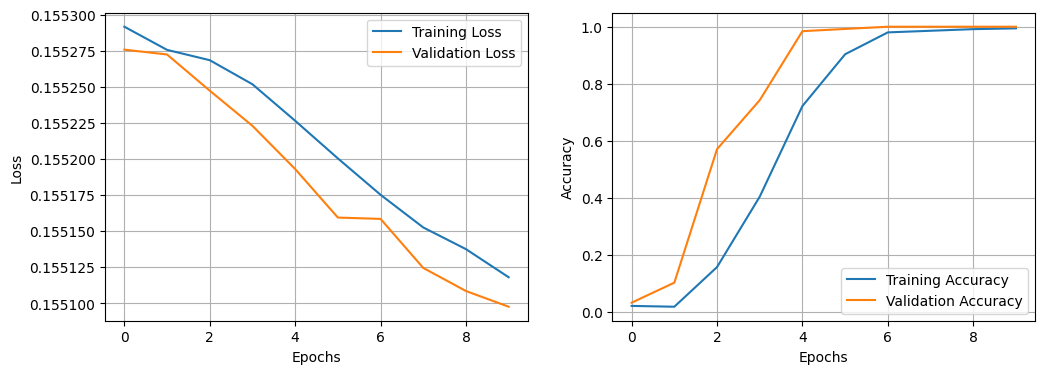

In [7]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.subplot(1, 2, 2)
plt.plot(history.history['my_accuracy'], label='Training Accuracy')
plt.plot(history.history['val_my_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

8/8 [==============================] - 1s 40ms/step
[ 0  0  1  1  2  2  3  3  4  4  5  5  6  6  7  7  8  8  9  9 10 10 11 11
 12 12 13 13 14 14 15 15 16 16 17 17 18 18 19 19 20 20 21 21 22 22 23 23
 24 24 25 25 26 26 27 27 28 28 29 29 30 30 31 31]
[ 0  0  1  1  2  2  3  3  4  4  5  5  6  6  7  7  8  8  9  9 10 10 11 11
 12 12 13 13 14 14 15 15 16 16 17 17 18 18 19 19 20 20 21 21 22 22 23 23
 24 24 25 25 26 26 27 27 28 28 29 29 30 30 31 31]


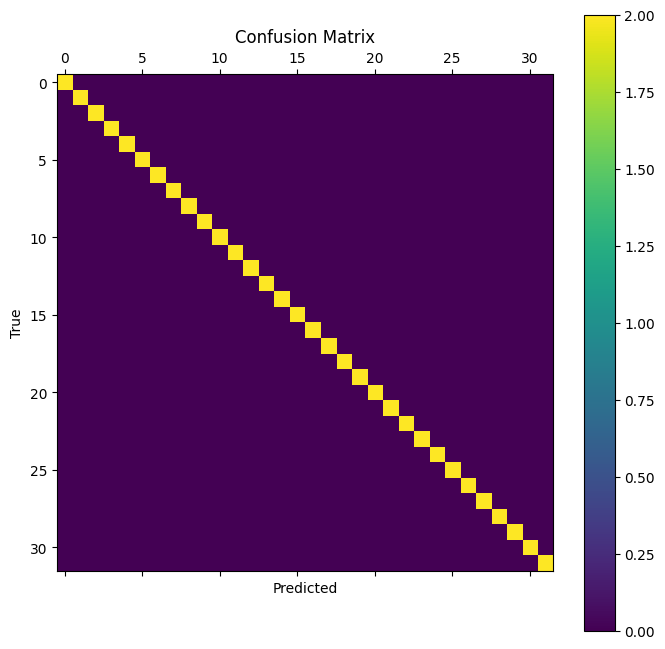

In [8]:
y_pred = ensemble_model.predict(test_generator)
y_pred = np.argmax(y_pred, axis=1)
y_true = test_generator.classes
print(y_pred)
print(y_true)
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, y_pred)
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion Matrix')
fig.colorbar(cax)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

ROC-AUC: 1.0000
Recall: 1.0000
Precision: 1.0000
Sensitivity: 1.0000
Specificity: 1.0000


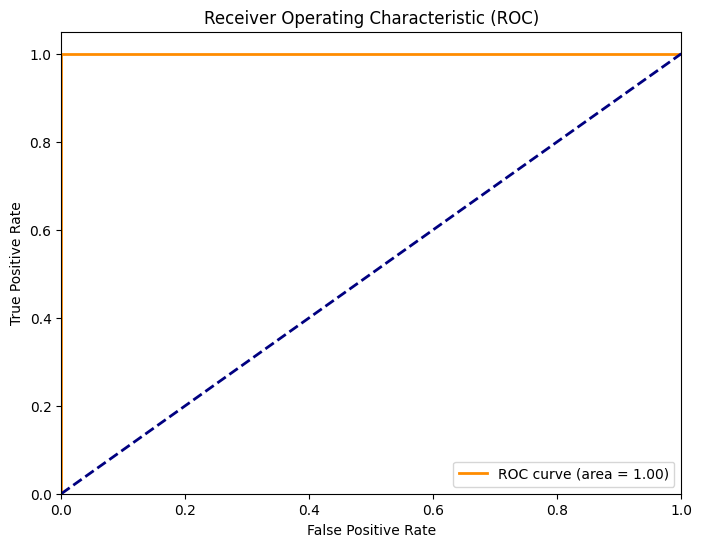

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, recall_score, precision_score, confusion_matrix, roc_curve, auc
from tensorflow.keras.utils import to_categorical

num_classes = 32
y_true_one_hot = to_categorical(y_true, num_classes=num_classes)
y_pred_one_hot = to_categorical(y_pred, num_classes=num_classes)

roc_auc = roc_auc_score(y_true_one_hot, y_pred_one_hot, average='macro', multi_class='ovr')
print(f'ROC-AUC: {roc_auc:.4f}')



y_pred_labels = np.argmax(y_pred_one_hot, axis=1)

recall = recall_score(y_true, y_pred_labels, average='macro')
print(f'Recall: {recall:.4f}')


precision = precision_score(y_true, y_pred_labels, average='macro')
print(f'Precision: {precision:.4f}')


confusion = confusion_matrix(y_true, y_pred_labels)
sensitivity = confusion[1, 1] / (confusion[1, 0] + confusion[1, 1])
specificity = confusion[0, 0] / (confusion[0, 0] + confusion[0, 1])
print(f'Sensitivity: {sensitivity:.4f}')
print(f'Specificity: {specificity:.4f}')


fpr, tpr, _ = roc_curve(y_true_one_hot.ravel(), y_pred_one_hot.ravel())
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         2
           3       1.00      1.00      1.00         2
           4       1.00      1.00      1.00         2
           5       1.00      1.00      1.00         2
           6       1.00      1.00      1.00         2
           7       1.00      1.00      1.00         2
           8       1.00      1.00      1.00         2
           9       1.00      1.00      1.00         2
          10       1.00      1.00      1.00         2
          11       1.00      1.00      1.00         2
          12       1.00      1.00      1.00         2
          13       1.00      1.00      1.00         2
          14       1.00      1.00      1.00         2
          15       1.00      1.00      1.00         2
          16       1.00      1.00      1.00         2
   

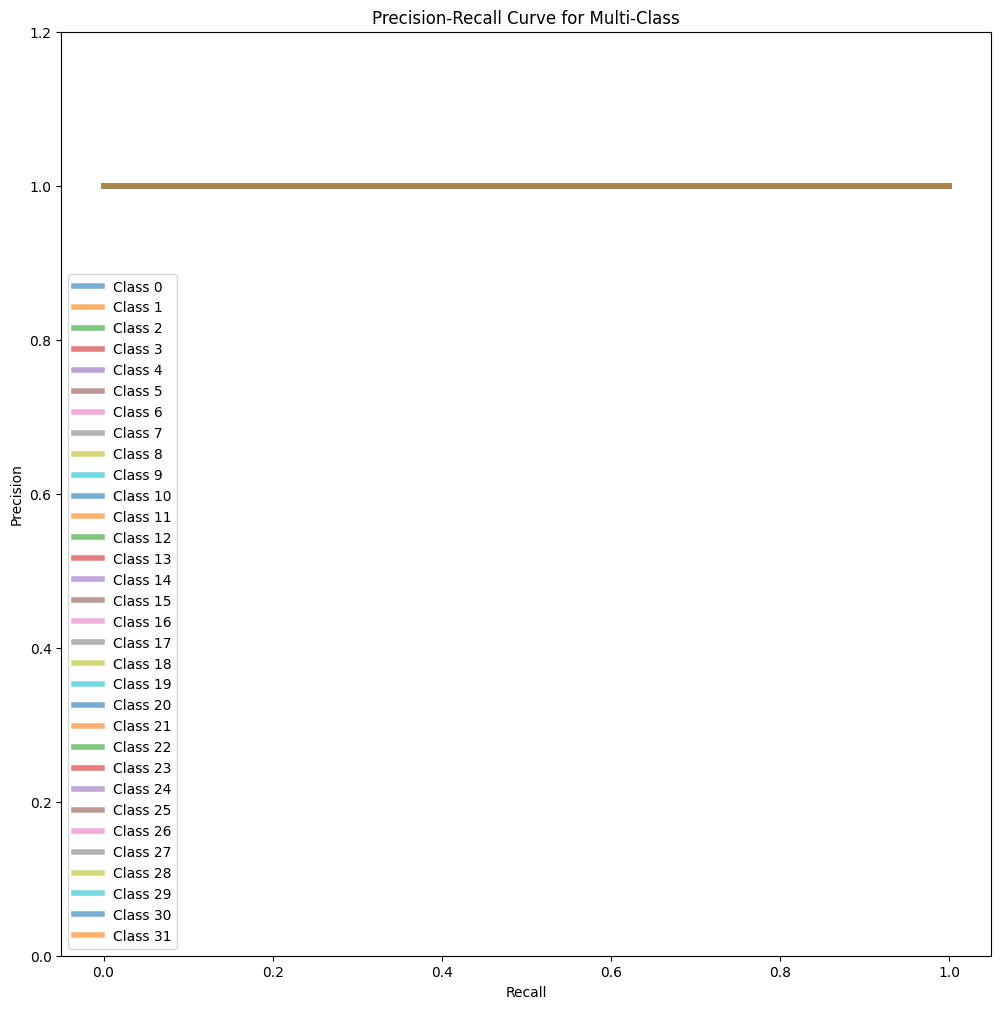

In [10]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import classification_report

precision = dict()
recall = dict()
for i in range(num_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_true == i, y_pred_one_hot[:, i])


plt.figure(figsize=(12,12))
lw = 4
for i in range(num_classes):
    plt.plot(recall[i], precision[i], lw=lw,
             label='Class {0}'.format(i),alpha=0.6)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Multi-Class')
plt.legend(loc="best")
plt.ylim(0,1.2)
classification_rep = classification_report(y_true, y_pred_labels)

print("Classification Report:\n", classification_rep)

plt.show()